Q1a:

MySql Statement:

select e1.name as EmployeeName <br/>
from Employee as e1, Employee as e2 <br/>
where e1.manager_id = e2.id AND e1.Salary > e2.Salary <br/>
<br/>

Explanation: 

Selecting the name will output the employee's name and selecting from 2 tables will get the Cartesian Product (each row in the first table is paired with all the rows in the second table) of these 2 tables. The 2 conditions in the where clause is used to filter for the names of employees whose salaries are greater than their immediate manager's. <br/>
<br/>
df1.merge(df2, how='cross') to get Cartesian Product of 2 dataframes using pandas

Q1b:

Use python pandas to load Employee table <br/>
<br/>
To find out employees who do not manage anyone, filter out the NULL values in the manager_id col first and check the values in the manager_id col against the values in the id col. For the values in the manager_id col that appeared in the id col, it means that the employee with that specific id manages someone. For the remaining id values, we can sum up their corresponding salary and divide by the count to get the average salary.

Q2:

In [13]:
def exists(v):
    try:
        v
    except NameError:
        return False # v is not defined since there is NameError
    else:
        return True # v is defined


Q3:

In [9]:
import math
def pascalLayer(n):
    
    def binomialCoeff(line, i): # each entry in a layer is a value of a Binomial Coefficient which can be computed using combinations formula
        return math.comb(line, i) # line represents the layer and i represents the entry position in the layer
    
    for line in range(0, n):  # iterate through each layer and print the entries in each layer
        for i in range(0, line + 1): # number of values in each layer is equal to the layer number
            print(binomialCoeff(line, i), " ", end = "")
        print()

pascalLayer(4)

1  
1  1  
1  2  1  
1  3  3  1  


Q4:

Value at Risk, or VaR, is a threshold with a given confidence level that losses will not (or more accurately, will not historically) exceed a certain level. <br/>
<br/>
Conditional Value at Risk, or CVaR, is an estimate of expected losses sustained in the worst 1 - x% of scenarios.

[*********************100%***********************]  7 of 7 completed


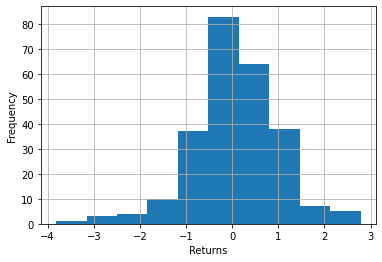

-1.4663853181955373
-2.2091078471798555


In [13]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Q4a: Historical method

# Data fetching
tickers = ['AAPL', 'IBM', 'GOOG', 'BP', 'XOM', 'COST', 'GS']
df = yf.download(tickers, "2016-01-01", "2016-12-31") # downloading data for all stocks in portfolio

# The adjusted closing price amends a stock's closing price to reflect that stock's value after accounting for any corporate actions. 
# It is often used when examining historical returns or doing a detailed analysis of past performance

df = df[["Adj Close"]] # only Adjusted Close col for each stock is required to calculate returns
returns_df = pd.DataFrame(df["Adj Close"].pct_change()) # returns is calculated by finding the percentage change compared to previous day
returns_df = returns_df * 100 # convert to percentages
returns_df = returns_df.dropna() # drop rows with na values
#print(returns_df.head())

weights = [0.15, 0.2, 0.2, 0.15, 0.1, 0.15, 0.05] # multiple stocks with different weights
portfolio = (weights * returns_df.values).sum(axis = 1) # for each day, each weight is multiplied by its return and then summed up to get daily portfolio return
plt.hist(portfolio)
plt.xlabel('Returns')
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

VaR_95 = np.percentile(portfolio, 5)
print(VaR_95) # 95% certain that losses will not exceed 1.47% in a given day based on historical values.

CVaR_95 = portfolio[portfolio <= VaR_95].mean()
print(CVaR_95) # In the worst 5% of cases, losses were on average 2.21% historically.





Q4b: Parametric Method

Assumptions: <br/>

a) Calculation of VaR in this case assumes that the returns of each stock in the portfolio are normally distributed.

In [33]:
from scipy.stats import norm


# Data fetching
tickers = ['AAPL', 'IBM', 'GOOG', 'BP', 'XOM', 'COST', 'GS']
weights = np.array([0.15, 0.2, 0.2, 0.15, 0.1, 0.15, 0.05])
df1 = yf.download(tickers, "2016-01-01", "2016-12-31") # downloading data for all stocks in portfolio
df1 = df1[["Adj Close"]] # only Adjusted Close col for each stock is required to calculate returns
returns_df1 = pd.DataFrame(df1["Adj Close"].pct_change()) # returns is calculated by finding the percentage change
returns_df1 = returns_df1 * 100 # convert to percentages
returns_df1 = returns_df1.dropna() # drop rows with na values

# Generate covariance matrix
cov_matrix = returns_df1.cov()

# Average returns for each stock
avg_returns = returns_df1.mean()

# Calculate mean returns for overall portfolio by using dot product to normalize individual means against investment weight
portfolio_mean = avg_returns.dot(weights)

# Calculate portfolio standard deviation
portfolio_stdev = np.sqrt(weights.T.dot(cov_matrix).dot(weights))

# Using SciPy ppf method to generate values for the inverse cumulative distribution function to a normal distribution
# Plugging in the mean, standard deviation of our portfolio as calculated above
VaR_95_param = norm.ppf(1 - 0.95, portfolio_mean, portfolio_stdev) 
print(VaR_95_param) # 95% certain that losses will not exceed 1.48% in a given day based on historical values.

CVaR_95_param = portfolio[portfolio <= VaR_95_param].mean()
print(CVaR_95_param) # In the worst 5% of cases, losses were on average 2.21% historically.


2016-02-01
[*********************100%***********************]  7 of 7 completed
-1.4765021139021492
-2.2091078471798555


Conclusion: Since the VaR95% of both methods are similar, the assumption of the returns of each stock in the portfolio being normally distributed is valid.

Q4c): Mean-variance Portfolio Optimisation <br/>
<br/>
Based on Harry Markowitz's 1952 paper, the key insight is that by combining assets with different expected returns and volatilities, one can decide on a mathematically optimal allocation which minimises the risk for a target return – the set of all such optimal portfolios is referred to as the efficient frontier as shown below.

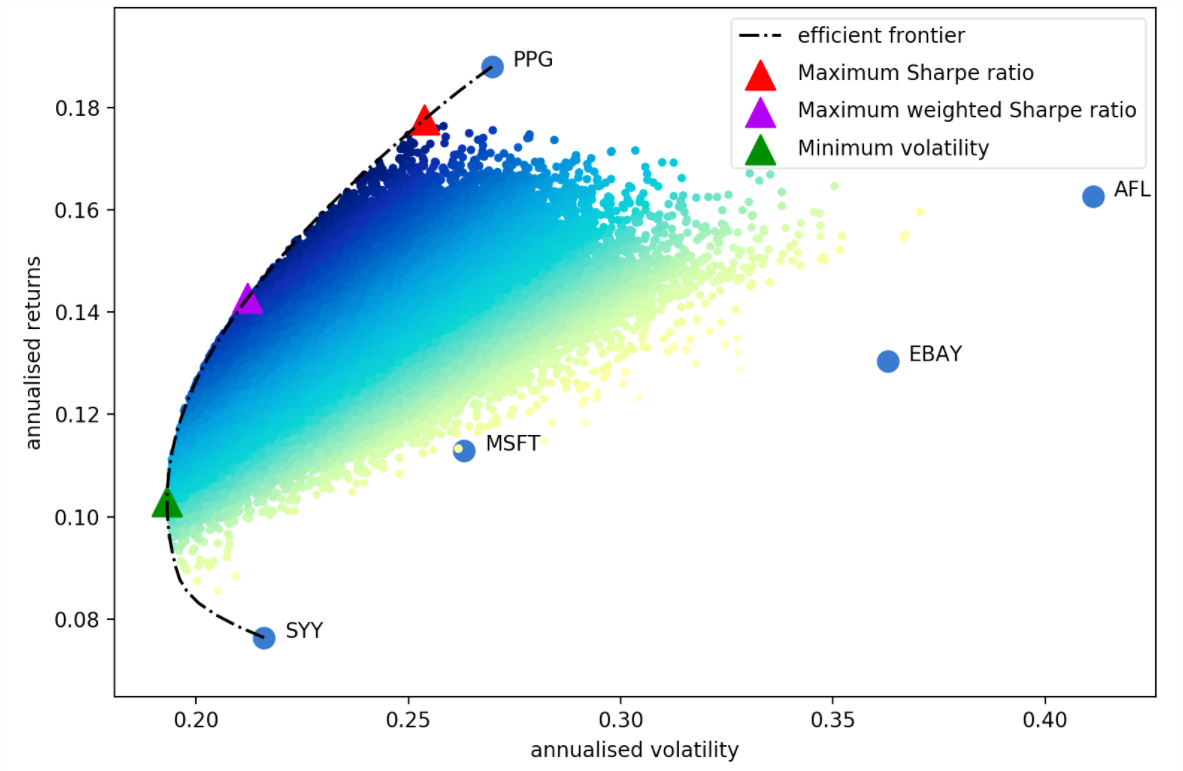

In [39]:
from IPython.display import Image
Image(filename='Efficient_Frontier.png') 

Assumptions: <br/>
<br/>
a) In this case, portfolio optimisation refers to maximising the returns, hence we obtain the optimal weights by maximising the Sharpe ratio as shown above.

In [38]:
from pypfopt import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct', 'Nov','Dec']
tickers = ['AAPL', 'IBM', 'GOOG', 'BP', 'XOM', 'COST', 'GS']
dict_port = {}

for m in range(1,13):   
    df2 = yf.download(tickers, "2016-" + str(m).zfill(2)+ "-01", period = '1mo') # downloading data for all stocks for each month
    df2 = df2[["Adj Close"]] # only Adjusted Close col for each stock is required to calculate returns

    # Calculate expected returns and covariance matrix
    mu = expected_returns.mean_historical_return(df2)
    cov_mat = risk_models.sample_cov(df2)

    # Optimize for maximal Sharpe ratio
    ef_frontier = EfficientFrontier(mu, cov_mat, weight_bounds = (-1,1)) # weight bounds to cater to short positions
    raw_weights = ef_frontier.max_sharpe()
    cleaned_weights = ef_frontier.clean_weights()
    lst = []
    for key, value in cleaned_weights.items():
        lst.append(value)
    dict_port[months[m-1]] = lst

df_port = pd.DataFrame(dict_port, index = tickers)
print(df_port)


[*********************100%***********************]  7 of 7 completed
[*********************100%***********************]  7 of 7 completed
[*********************100%***********************]  7 of 7 completed
[*********************100%***********************]  7 of 7 completed
[*********************100%***********************]  7 of 7 completed
[*********************100%***********************]  7 of 7 completed
[*********************100%***********************]  7 of 7 completed
[*********************100%***********************]  7 of 7 completed
[*********************100%***********************]  7 of 7 completed
[*********************100%***********************]  7 of 7 completed
[*********************100%***********************]  7 of 7 completed
[*********************100%***********************]  7 of 7 completed
          Jan      Feb      Mar      Apr      May      Jun      Jul      Aug  \
AAPL  0.76280  0.76549  0.68857  0.66946  0.79618  0.74083  0.80340  0.84456   
IBM   0.1200

Q5:

In [3]:
import os

# Q5a)

def countPyFiles():
    counter = 0
    path = "C:/NUS/Internships/Treehouse/Interview Qns (GitHub)/quant_interview_questions" # folder path
    for file in os.listdir(path): # navigate to folder path
        if file.endswith(".py"): # for every file that ends with .py, increment counter by 1
            counter += 1
    print(counter)

countPyFiles()

1


In [4]:
# Q5b)

def countLines():
    codeLines = 0
    commentLines = 0
    path = "C:/NUS/Internships/Treehouse/Interview Qns (GitHub)/quant_interview_questions"
    for file in os.listdir(path): # navigate to folder path
        if file.endswith(".py"): # python files
            for line in open(file):
                if line.rstrip(): # to filter out empty lines, rstrip: remove trailing characters
                    if line.startswith("#"): # to filter for comment lines and increment commentLines counter
                        commentLines += 1
                    codeLines += 1 # increment total codeLines counter
    print(codeLines)
    print(commentLines)

countLines()

4
2


In [5]:
# Q5c)

def countFunc():
    count = 0
    path = "C:/NUS/Internships/Treehouse/Interview Qns (GitHub)/quant_interview_questions"
    for file in os.listdir(path): # navigate to folder path
        if file.endswith(".py"): # python files
            for line in open(file):
                if line.startswith("def"): # to filter for lines starting with def since functions start with def
                    count += 1

    print(count)

countFunc()

1


Q5d) <br/>
<br/>

Install gitpython and use the command (git diff --stat HEAD~3 HEAD) to get the lines of changes. This will show the combined stats for the last 3 commits relative to current commit.

Q5e) <br/>
<br/>

For each subfolder (down to 2 level depth), use (os.path.getsize(file_path)) to get the size of a file in bytes. Divide file size by 1024 x 1024 to get file size in MB. Then sum the size of each file to get the total size of the folder. For higher level folders, sum the size of the nested folders and the size of each individual file together.

Q6:

In [10]:
import datefinder

contents = 0
with open('Q6.txt') as f: # opening txt file and reading its contents
    contents = f.read()
    f.close()

matches = datefinder.find_dates(contents) # using datefinder library to find any date appearances in the contents

counter = 0
for match in matches: 
    counter += 1  # count the total number of date appearances

print(counter)

5
